In [ ]:
# !/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Code tutorial for inverse probelms
J. Sulam
"""

# Basic imports
from pathlib import Path
import numpy as np
from imageio.v3 import imread
import matplotlib.pyplot as plt

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

x0 shape: (1428, 1730, 3), dtype: float32, min/max: 0.00/1.00


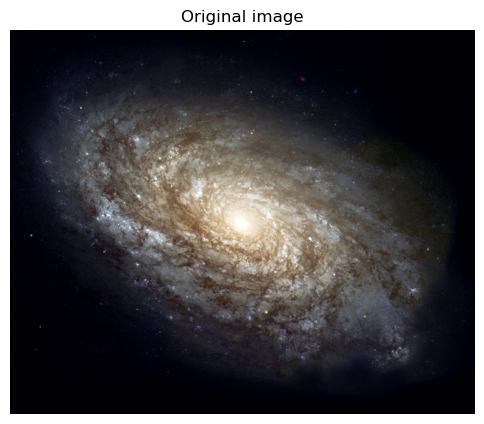

In [12]:
# Loading image

img_path = Path("galaxy.jpg")
if not img_path.exists():
    raise FileNotFoundError(
        "Could not find 'galaxy.png' in the current folder. "
        "Place the image next to the notebook and re-run."
    )

# Read the image; keep as float32 in range [0, 255]
x0_raw = imread(img_path)

# Read the image; keep as float32 in range [0, 255]
x0_raw = imread(img_path)

# Convert to float32 and scale to [0,1]
if np.issubdtype(x0_raw.dtype, np.integer):
    x0 = x0_raw.astype(np.float32) / 255.0
else:
    x0 = x0_raw.astype(np.float32)
    # If the image was already in [0,255], rescale; otherwise assume it's already in [0,1]
    vmax = np.max(x0)
    if vmax > 1.5:
        x0 = x0 / 255.0

print(f"x0 shape: {x0.shape}, dtype: {x0.dtype}, min/max: {x0.min():.2f}/{x0.max():.2f}")

plt.figure(figsize=(6, 6))
plt.imshow(x0)
plt.axis("off")
plt.title("Original image")
plt.show()


MSE: 0.046508, PSNR: 13.32 dB SSIM: 0.5963


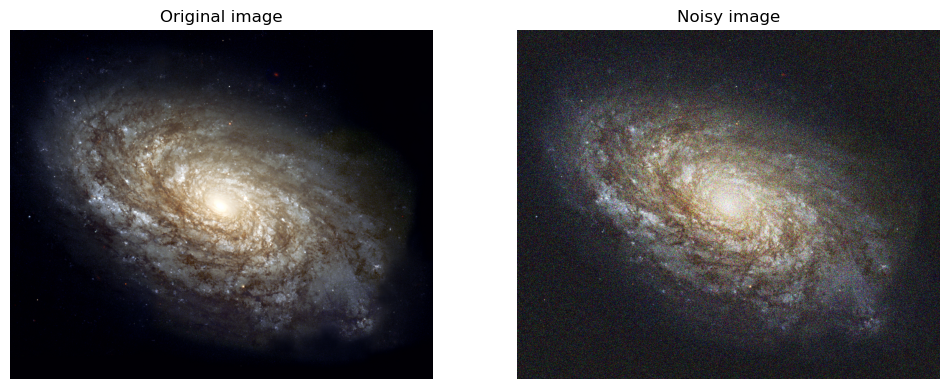

In [ ]:
# Step 2: Create noisy version y with Gaussian noise (σ ≈ 20 on [0,255] scale → 0.078 on [0,1])

rng = np.random.default_rng(42)
sigma = 70.0 / 255.0  # noise std on [0,1] scale
noise = rng.normal(loc=0.0, scale=sigma, size=x0.shape).astype(np.float32)

y = np.clip(x0 + noise, 0.0, 1.0)

# define mse function and psnr function
def mse(a, b):
    return float(np.mean((a - b)**2))

def psnr(a, b, data_range=1.0):
    m = mse(a, b)
    if m == 0:
        return float('inf')
    return 10.0 * np.log10((data_range**2) / m)

# import SSIM from skimage and adjust win_size parameter
from skimage.metrics import structural_similarity as ssim
# Calculate SSIM with appropriate parameters
win_size = min(x0.shape[0], x0.shape[1]) if min(x0.shape[0], x0.shape[1]) % 2 == 1 else min(x0.shape[0], x0.shape[1]) - 1
ssim_value = ssim(x0, y, data_range=1.0, win_size=win_size, channel_axis=-1)

print(f"MSE: {mse(x0, y):.6f}, PSNR: {psnr(x0, y):.2f} dB", f"SSIM: {ssim_value:.4f}")

# Display noisy image next to original
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(x0)
plt.axis("off")
plt.title("Original image")
plt.subplot(1, 2, 2)
plt.imshow(y)
plt.axis("off")
plt.title(f"Noisy image")
plt.show()

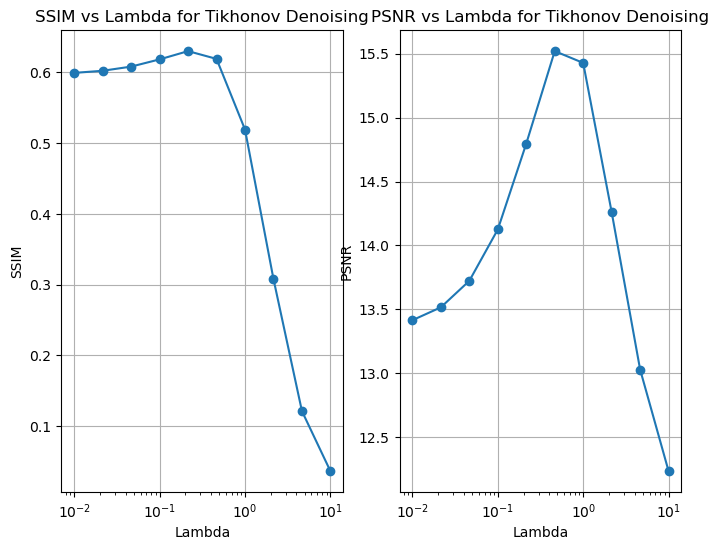

Best lambda: 0.46415888336127775, MSE: 0.028049, PSNR: 15.52 dB, SSIM: 0.6188


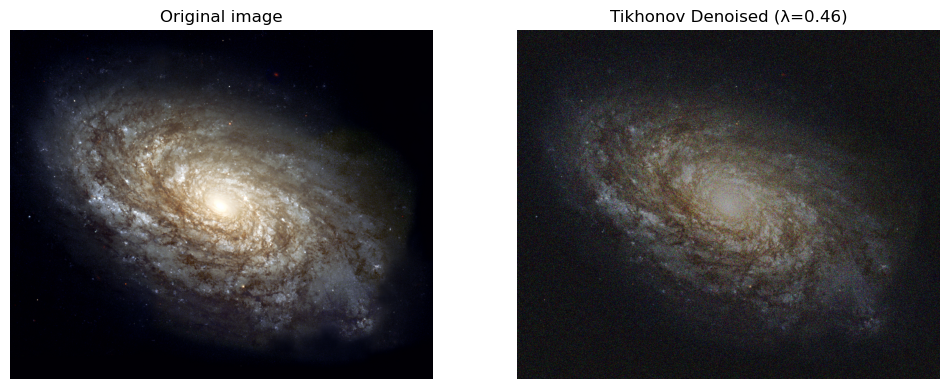

In [64]:
# Implementing L2 Tikhonov denoising

# Choose a set of lambdas to try in log scale
lambdas = np.logspace(-2, 1, num=10)

tik_results = []
for lam in lambdas:
    x_tik = y / (1.0 + lam)              # closed form
    x_tik = np.clip(x_tik, 0.0, 1.0)     # keep in [0,1] for safety
    err_mse = mse(x_tik, x0)
    err_psnr = psnr(x_tik, x0, data_range=1.0)
    err_ssim = ssim(x_tik, x0, data_range=1.0, win_size=win_size, channel_axis=-1)
    tik_results.append({"lambda": lam, "x": x_tik, "mse": err_mse, "psnr": err_psnr, "ssim": err_ssim})

# Plot err_ssim vs lambda
plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)
plt.semilogx([r["lambda"] for r in tik_results], [r["ssim"] for r in tik_results], marker='o')
plt.xlabel("Lambda")
plt.ylabel("SSIM")
plt.title("SSIM vs Lambda for Tikhonov Denoising")
plt.grid(True)
plt.subplot(1, 2, 2)
plt.semilogx([r["lambda"] for r in tik_results], [r["psnr"] for r in tik_results], marker='o')
plt.xlabel("Lambda")
plt.ylabel("PSNR")
plt.title("PSNR vs Lambda for Tikhonov Denoising")
plt.grid(True)
plt.show()

# pick the best result based on PSNR and display the original, noisy, and best denoised images
tik_results.sort(key=lambda d: d["psnr"], reverse=True)
best = tik_results[0]
print(f"Best lambda: {best['lambda']}, MSE: {best['mse']:.6f}, PSNR: {best['psnr']:.2f} dB, SSIM: {best['ssim']:.4f}")  
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(x0)
plt.axis("off")
plt.title("Original image")
plt.subplot(1, 2, 2)
plt.imshow(best["x"])
plt.axis("off")
plt.title(f"Tikhonov Denoised (λ={best['lambda']:.2f})")
plt.show()

In [56]:
# Defining ISTA and utility functions

def vec(img):
    return img.reshape(-1)

def dev(v, shape):
    return v.reshape(shape)

def soft_threshold(u, tau):
    return np.sign(u) * np.maximum(np.abs(u) - tau, 0.0)

def spectral_norm(A, iters=50, tol=1e-8, seed=0):
    """Estimate ||A||_2 via power iteration on A^T A."""
    rng = np.random.default_rng(seed)
    n = A.shape[1]
    x = rng.standard_normal(n).astype(np.float32)
    x /= np.linalg.norm(x) + 1e-12
    prev = 0.0
    for _ in range(iters):
        x = A.T @ (A @ x)
        x_norm = np.linalg.norm(x) + 1e-12
        x /= x_norm
        val = float(x @ (A.T @ (A @ x)))
        if abs(val - prev) < tol * max(1.0, prev):
            break
        prev = val
    return np.sqrt(max(val, 0.0))

def ista_l1_matrix(A, y_img, lam, x_shape, x_init=None, max_iter=300, step=None, tol=1e-6, clip01=True, verbose=True):
    """
    Solve min_x ||y - A x||^2 + lam||x||_1 with ISTA.
    A: either a NumPy matrix (m x n) or the string "I" for identity.
    y_img: measurement as image-shaped array (will be flattened)
    x_shape: target image shape to reshape the solution into
    """
    y_vec = vec(y_img)

    # initialize x
    if x_init is None:
        x = y_vec.copy() if A == "I" else (A.T @ y_vec).astype(np.float32)
    else:
        x = vec(x_init).astype(np.float32)

    # step size
    if step is None:
        if A == "I":
            normA = 1.0
        else:
            normA = spectral_norm(A)
        L = 2.0 * (normA ** 2)        # because grad of ||y-Ax||^2 is 2 A^T (Ax - y)
        step = 1.0 / (L + 1e-12)
        if verbose:
            print(f"Estimated ||A|| ≈ {normA:.6f}, L≈{L:.6f}, step≈{step:.6f}")
    else:
        if verbose:
            print(f"Using provided step={step:.6f}")

    def apply_A(u):
        return u if A == "I" else (A @ u)

    def apply_AT(v):
        return v if A == "I" else (A.T @ v)

    def objective(xv):
        r = y_vec - apply_A(xv)
        return float(r @ r) + lam * float(np.sum(np.abs(xv)))

    obj_vals = []
    for k in range(1, max_iter + 1):
        r = apply_A(x) - y_vec
        grad = 2.0 * apply_AT(r)
        x_next = soft_threshold(x - step * grad, step * lam)

        if clip01:
            x_next = np.clip(x_next, 0.0, 1.0)

        if (k == 1) or (k % 10 == 0):
            obj_vals.append(objective(x_next))
            if verbose and k % 50 == 0:
                print(f"Iter {k:4d}: obj={obj_vals[-1]:.6f}")

        rel = np.linalg.norm(x_next - x) / (np.linalg.norm(x) + 1e-12)
        x = x_next
        if rel < tol:
            if verbose:
                print(f"Converged at iter {k} (rel change {rel:.2e})")
            break

    return dev(x, x_shape), {"step": step, "iters": k, "obj_vals": obj_vals}

Sweeping λ values...



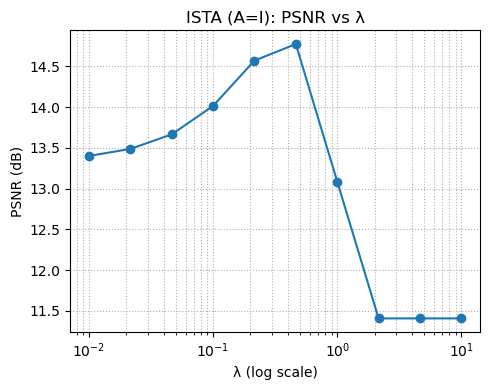

λ sweep results (sorted by MSE):
         λ |        MSE |  PSNR(dB) | iters
--------------------------------------------
  0.464159 |   0.033316 |     14.77 |     2
  0.215443 |   0.034913 |     14.57 |     2
  0.100000 |   0.039682 |     14.01 |     2
  0.046416 |   0.043002 |     13.67 |     2
  0.021544 |   0.044805 |     13.49 |     2
  0.010000 |   0.045701 |     13.40 |     2
  1.000000 |   0.049124 |     13.09 |     2
  2.154435 |   0.072315 |     11.41 |     2
  4.641589 |   0.072315 |     11.41 |     2
 10.000000 |   0.072315 |     11.41 |     2

Best by MSE: λ=0.464159 (MSE=0.033316, PSNR=14.77 dB, iters=2)


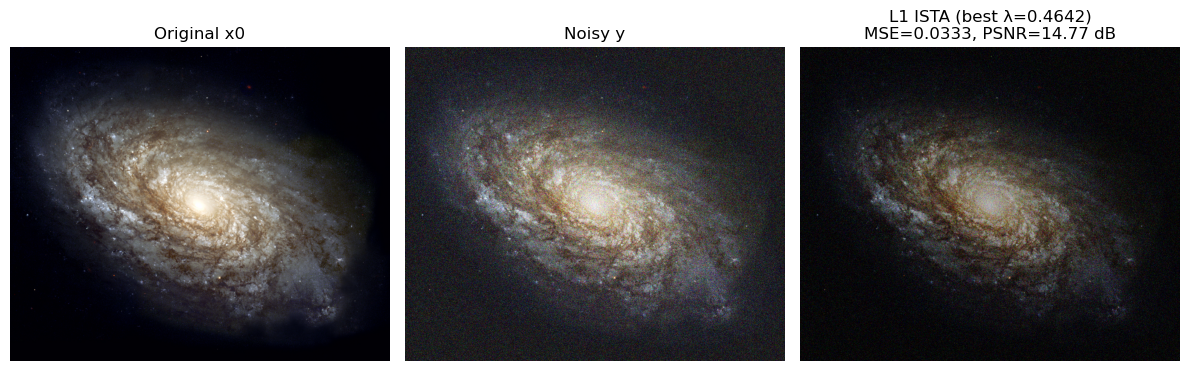

In [ ]:
# Applying ISTA with A = I (just L1)

# Log-spaced sweep works well for sparsity weights on [0,1] images
lambdas = np.logspace(-2, 1, num=10)

results = []
print("Sweeping λ values...\n")
for lam in lambdas:
    x_l1, info = ista_l1_matrix(
        "I",
        y_img=y,
        lam=float(lam),
        x_shape=x0.shape,
        x_init=y,           # warm start
        max_iter=300,
        tol=1e-5,
        verbose=False
    )
    m = mse(x_l1, x0)
    p = psnr(x_l1, x0, data_range=1.0)
    results.append({"lambda": float(lam), "x": x_l1, "mse": m, "psnr": p, "iters": info["iters"], "step": info["step"]})

# Plot PSNR vs λ
plt.figure(figsize=(5,4))
plt.semilogx([r["lambda"] for r in results], [r["psnr"] for r in results], marker="o")
plt.xlabel("λ (log scale)")
plt.ylabel("PSNR (dB)")
plt.title("ISTA (A=I): PSNR vs λ")
plt.grid(True, which="both", ls=":")
plt.tight_layout()
plt.show()

# Rank by MSE (lower is better)
results.sort(key=lambda r: r["mse"])
best = results[0]

# Visualize original, noisy, and best result
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(x0 if x0.ndim==3 else x0, cmap="gray" if x0.ndim==2 else None); plt.axis("off"); plt.title("Original x0")
plt.subplot(1,3,2); plt.imshow(y  if y.ndim==3  else y,  cmap="gray" if y.ndim==2  else None); plt.axis("off"); plt.title("Noisy y")
plt.subplot(1,3,3); 
plt.imshow(best["x"] if best["x"].ndim==3 else best["x"], cmap="gray" if best["x"].ndim==2 else None); 
plt.axis("off")
plt.title(f"L1 ISTA (best λ={best['lambda']:.4g})\nMSE={best['mse']:.4f}, PSNR={best['psnr']:.2f} dB")
plt.tight_layout()
plt.show()

In [ ]:
## TV-like method

# --- finite differences (forward) and divergence (adjoint) ---
def grad_img(img):
    # img: HxW or HxWxC
    if img.ndim == 2:
        img = img[..., None]
    H, W, C = img.shape
    gx = np.zeros_like(img, dtype=np.float32)  # horizontal
    gy = np.zeros_like(img, dtype=np.float32)  # vertical
    gx[:, :-1, :] = img[:, 1:, :] - img[:, :-1, :]
    gy[:-1, :, :] = img[1:, :, :] - img[:-1, :, :]
    return gx, gy  # each HxWxC

def div_img(gx, gy):
    # adjoint of grad under Neumann BCs (zero derivative outside)
    H, W, C = gx.shape
    out = np.zeros_like(gx, dtype=np.float32)
    # x-direction
    out[:, :-1, :] -= gx[:, :-1, :]
    out[:, 1:,  :] += gx[:, :-1, :]
    # y-direction
    out[:-1, :, :] -= gy[:-1, :, :]
    out[1:,  :, :] += gy[:-1, :, :]
    return out  # HxWxC

# --- a tiny adapter that "looks like a matrix": supports @ and .T @ ---
class _GradAdjoint:
    def __init__(self, H, W, C):
        self.H, self.W, self.C = H, W, C
    def __matmul__(self, v):
        # v is vectorized stacked gradients with shape (H,W,C,2)
        # unpack, apply divergence, return flattened image vector
        vw = v.reshape(self.H, self.W, self.C, 2)
        gx = vw[..., 0]
        gy = vw[..., 1]
        div = div_img(gx, gy)
        return div.reshape(-1)

class GradAsMatrix:
    def __init__(self, H, W, C=1):
        self.H, self.W, self.C = H, W, C
        self.T = _GradAdjoint(H, W, C)   # provide adjoint via .T
    def __matmul__(self, x):
        # x is flattened image vector -> return flattened stacked gradients
        img = x.reshape(self.H, self.W, self.C)
        gx, gy = grad_img(img)
        stacked = np.stack([gx, gy], axis=-1)  # HxWxCx2
        return stacked.reshape(-1)


# --- setup ---
H, W = x0.shape[:2]
C = 1 if x0.ndim == 2 else x0.shape[2]
A_tv = GradAsMatrix(H, W, C)

gx_y, gy_y = grad_img(y)
y_TV = np.stack([gx_y, gy_y], axis=-1)

step_tv = 1.0 / 16.0  # safe fixed step
lambdas = np.logspace(-2, 1, num=10)

results = []
print("Sweeping λ values...\n")

for lam in lambdas:
    x_tv_like, info = ista_l1_matrix(
        A_tv,
        y_img=y_TV,
        lam=float(lam),
        x_shape=x0.shape,
        x_init=y,
        max_iter=400,
        step=step_tv,
        tol=1e-5,
        clip01=True,
        verbose=False
    )
    m = mse(x_tv_like, x0)
    p = psnr(x_tv_like, x0)
    results.append({"lambda": float(lam), "x": x_tv_like, "mse": m, "psnr": p, "iters": info["iters"]})

# Sort and report
results.sort(key=lambda r: r["mse"])
best = results[0]

print("λ sweep results (sorted by MSE):")
print(f"{'λ':>10} | {'MSE':>10} | {'PSNR(dB)':>9} | {'iters':>5}")
print("-" * 44)
for r in results:
    print(f"{r['lambda']:10.4f} | {r['mse']:10.6f} | {r['psnr']:9.2f} | {r['iters']:5d}")

print(f"\nBest by MSE: λ={best['lambda']:.4f} "
      f"(MSE={best['mse']:.6f}, PSNR={best['psnr']:.2f} dB)")

# --- plot PSNR vs λ ---
plt.figure(figsize=(5,4))
plt.semilogx([r["lambda"] for r in results], [r["psnr"] for r in results], marker="o")
plt.xlabel("λ (log scale)")
plt.ylabel("PSNR (dB)")
plt.title("Gradient-domain fit + L1(x): PSNR vs λ")
plt.grid(True, which="both", ls=":")
plt.tight_layout()
plt.show()

# --- show best reconstruction ---
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(x0 if C>1 else x0, cmap=None if C>1 else "gray"); plt.axis("off"); plt.title("Original x0")
plt.subplot(1,3,2); plt.imshow(y  if C>1 else y,  cmap=None if C>1 else "gray"); plt.axis("off"); plt.title("Noisy y")
plt.subplot(1,3,3); plt.imshow(best["x"] if C>1 else best["x"], cmap=None if C>1 else "gray"); plt.axis("off")
plt.title(f"Grad-fit + L1(x)\nBest λ={best['lambda']:.3g}, MSE={best['mse']:.4f}, PSNR={best['psnr']:.2f} dB")
plt.tight_layout()
plt.show()

Sweeping λ values...

